**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.  

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)  
* F1 > 0.5, precision > 0.5, recall > 0.5 на X_test 

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}  
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}

In [1]:
import numpy as np
import pandas as pd
import random
import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/Kristina/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### Подключение библиотек и скриптов

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 50)

In [3]:
%config InlineBackend.figure_format = 'png'

**Пути к директориям и файлам**

In [4]:
# input
TRAIN_DATASET_PATH =  'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

### Загрузка данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита (0 - краткосрочный , 1 - долгосрочный)
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.00,NaN,0.00,11.00,26.30,685960.00,1.00,nan,1.00,debt consolidation,Short Term,99999999.00,47386.00,7914.00,749.00,0
1,Own Home,1025487.00,10+ years,0.00,15.00,15.30,1181730.00,0.00,nan,0.00,debt consolidation,Long Term,264968.00,394972.00,18373.00,737.00,1
2,Home Mortgage,751412.00,8 years,0.00,11.00,35.00,1182434.00,0.00,nan,0.00,debt consolidation,Short Term,99999999.00,308389.00,13651.00,742.00,0
3,Own Home,805068.00,6 years,0.00,8.00,22.50,147400.00,1.00,nan,1.00,debt consolidation,Short Term,121396.00,95855.00,11338.00,694.00,0
4,Rent,776264.00,8 years,0.00,13.00,13.60,385836.00,1.00,nan,0.00,debt consolidation,Short Term,125840.00,93309.00,7180.00,719.00,0


In [6]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,nan,4 years,0.00,9.00,12.50,220968.00,0.00,70.00,0.00,debt consolidation,Short Term,162470.00,105906.00,6813.00,nan
1,Rent,231838.00,1 year,0.00,6.00,32.70,55946.00,0.00,8.00,0.00,educational expenses,Short Term,78298.00,46037.00,2318.00,699.00
2,Home Mortgage,1152540.00,3 years,0.00,10.00,13.70,204600.00,0.00,nan,0.00,debt consolidation,Short Term,200178.00,146490.00,18729.00,7260.00
3,Home Mortgage,1220313.00,10+ years,0.00,16.00,17.00,456302.00,0.00,70.00,0.00,debt consolidation,Short Term,217382.00,213199.00,27559.00,739.00
4,Home Mortgage,2340952.00,6 years,0.00,11.00,23.60,1207272.00,0.00,nan,0.00,debt consolidation,Long Term,777634.00,425391.00,42605.00,706.00


In [7]:
train_df.shape, test_df.shape

((7500, 17), (2500, 16))

### Общая информации о данных

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [9]:
train_df.iloc[0]

Home Ownership                            Own Home
Annual Income                            482087.00
Years in current job                           NaN
Tax Liens                                     0.00
Number of Open Accounts                      11.00
Years of Credit History                      26.30
Maximum Open Credit                      685960.00
Number of Credit Problems                     1.00
Months since last delinquent                   NaN
Bankruptcies                                  1.00
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                    99999999.00
Current Credit Balance                    47386.00
Monthly Debt                               7914.00
Credit Score                                749.00
Credit Default                                   0
Name: 0, dtype: object

### Приведение типов

In [10]:
train_df['ID'] = train_df.index.tolist()
train_df.set_index('ID', inplace=True)

In [11]:
test_df['ID'] = test_df.index.tolist()
test_df.set_index('ID', inplace=True)

### Оценка распредения целевой переменной в разрезе других признаков

**Целевая переменная**

In [12]:
target_name = 'Credit Default'

In [13]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [14]:
base_feature_names = train_df.columns.drop(target_name).tolist()

In [15]:
base_feature_names

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

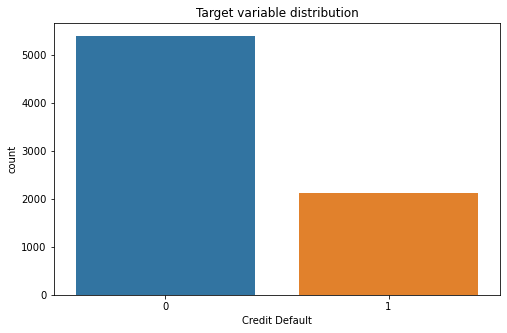

In [16]:
plt.figure(figsize=(8, 5))

sns.countplot(x=target_name, data=train_df)

plt.title('Target variable distribution')
plt.show()

**Корреляция с базовыми признаками**

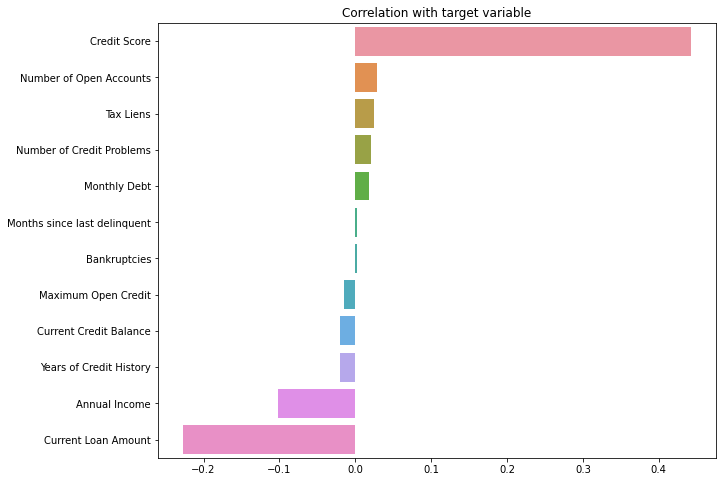

In [17]:
corr_with_target = train_df[base_feature_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

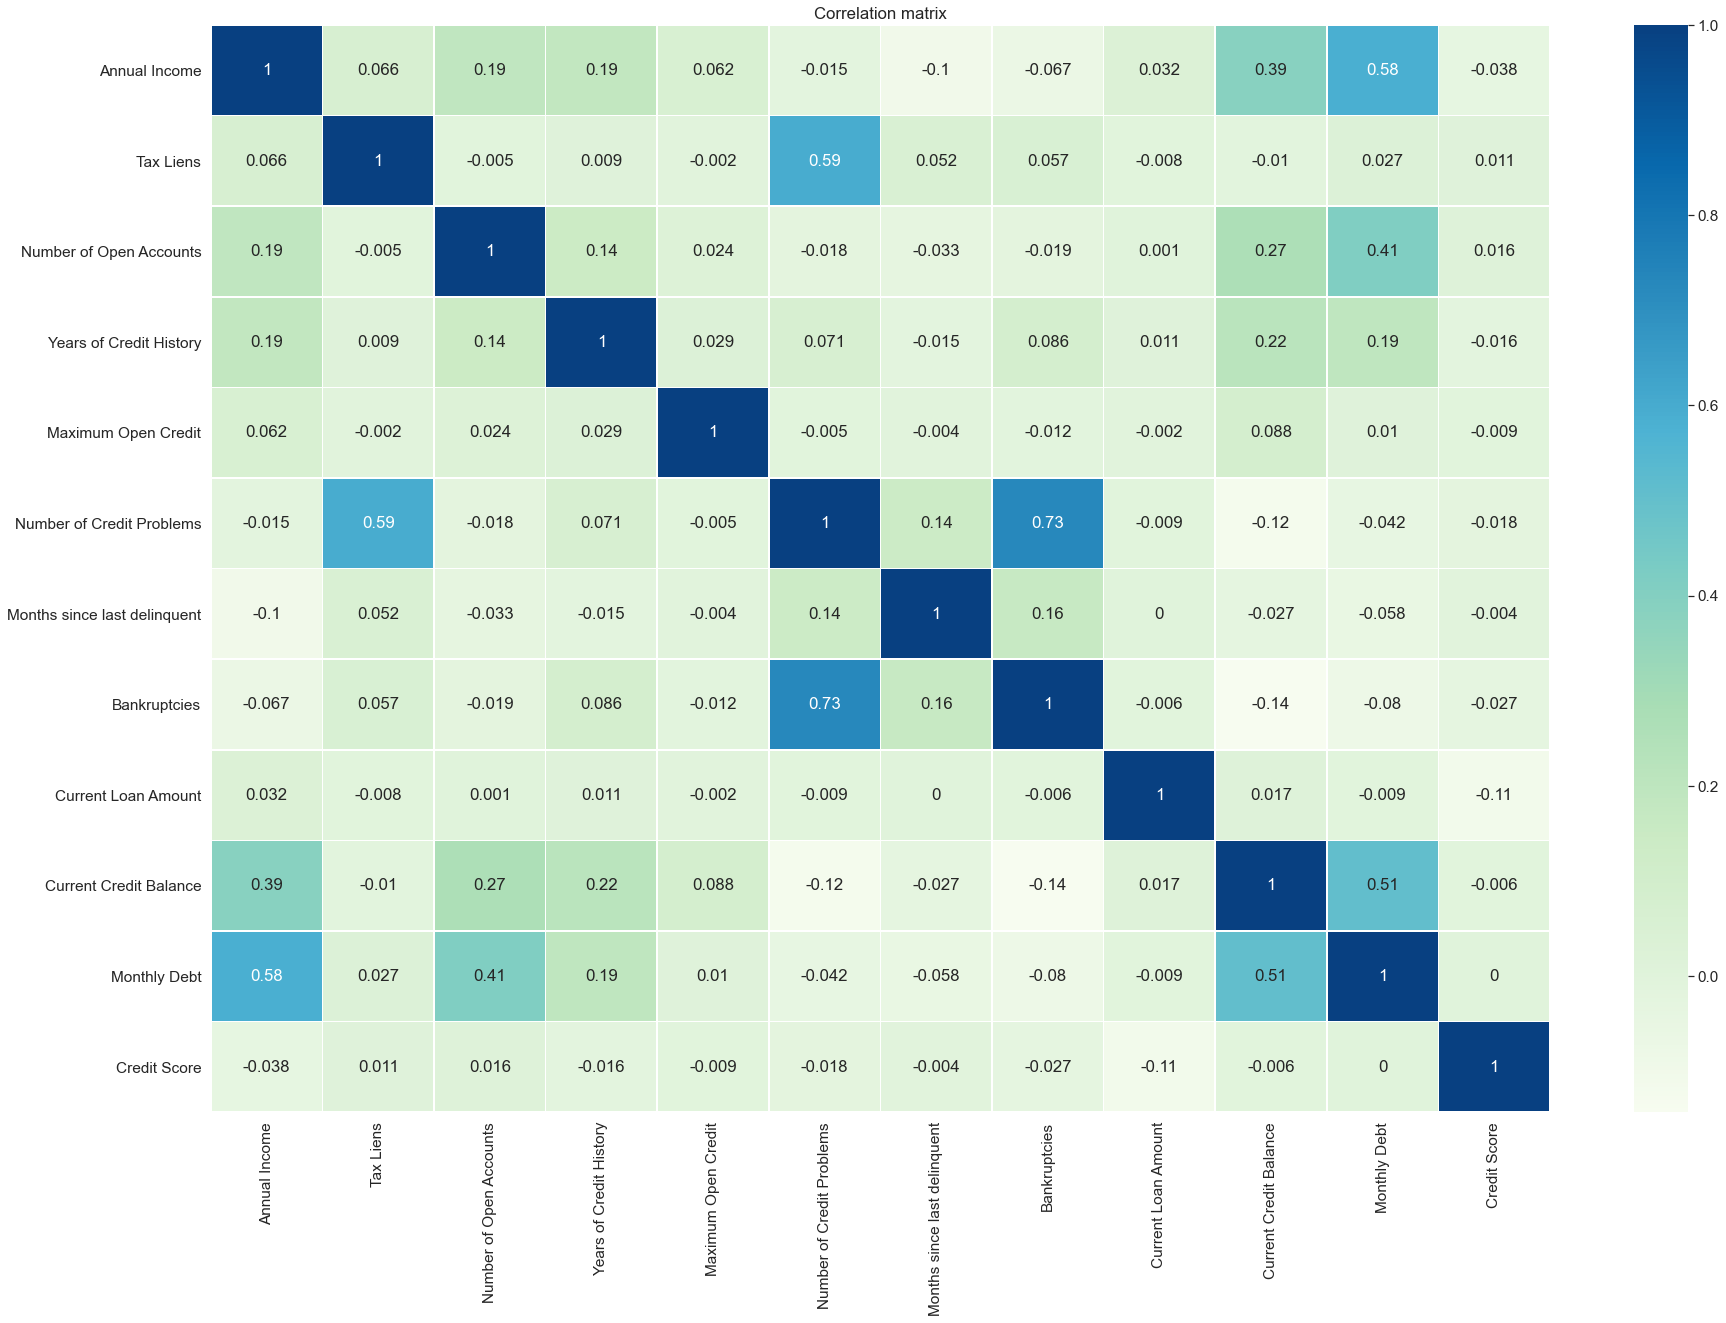

In [18]:
plt.figure(figsize = (30,20))

sns.set(font_scale=1.4)
sns.heatmap(train_df[base_feature_names].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Обзор данных

In [19]:
train_df.nunique()

Home Ownership                     4
Annual Income                   5478
Years in current job              11
Tax Liens                          8
Number of Open Accounts           39
Years of Credit History          408
Maximum Open Credit             6963
Number of Credit Problems          8
Months since last delinquent      89
Bankruptcies                       5
Purpose                           15
Term                               2
Current Loan Amount             5386
Current Credit Balance          6592
Monthly Debt                    6716
Credit Score                     268
Credit Default                     2
dtype: int64

**Обзор количественных признаков**

In [20]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5943.00,7500.00,7500.00,7500.00,7500.00,7500.00,3419.00,7486.00,7500.00,7500.00,7500.00,5943.00,7500.00
mean,1366391.72,0.03,11.13,18.32,945153.73,0.17,34.69,0.12,11873177.45,289833.24,18314.45,1151.09,0.28
std,845339.20,0.27,4.91,7.04,16026216.67,0.50,21.69,0.35,31926122.97,317871.38,11926.76,1604.45,0.45
min,164597.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,11242.00,0.00,0.00,585.00,0.00
25%,844341.00,0.00,8.00,13.50,279229.50,0.00,16.00,0.00,180169.00,114256.50,10067.50,711.00,0.00
50%,1168386.00,0.00,10.00,17.00,478159.00,0.00,32.00,0.00,309573.00,209323.00,16076.50,731.00,0.00
75%,1640137.00,0.00,14.00,21.80,793501.50,0.00,50.00,0.00,519882.00,360406.25,23818.00,743.00,1.00
max,10149344.00,7.00,43.00,57.70,1304726170.00,7.00,118.00,4.00,99999999.00,6506797.00,136679.00,7510.00,1.00


In [21]:
feature_num_names = train_df.drop('Credit Default', axis=1).select_dtypes(include=['float64']).columns.tolist()
feature_num_names

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

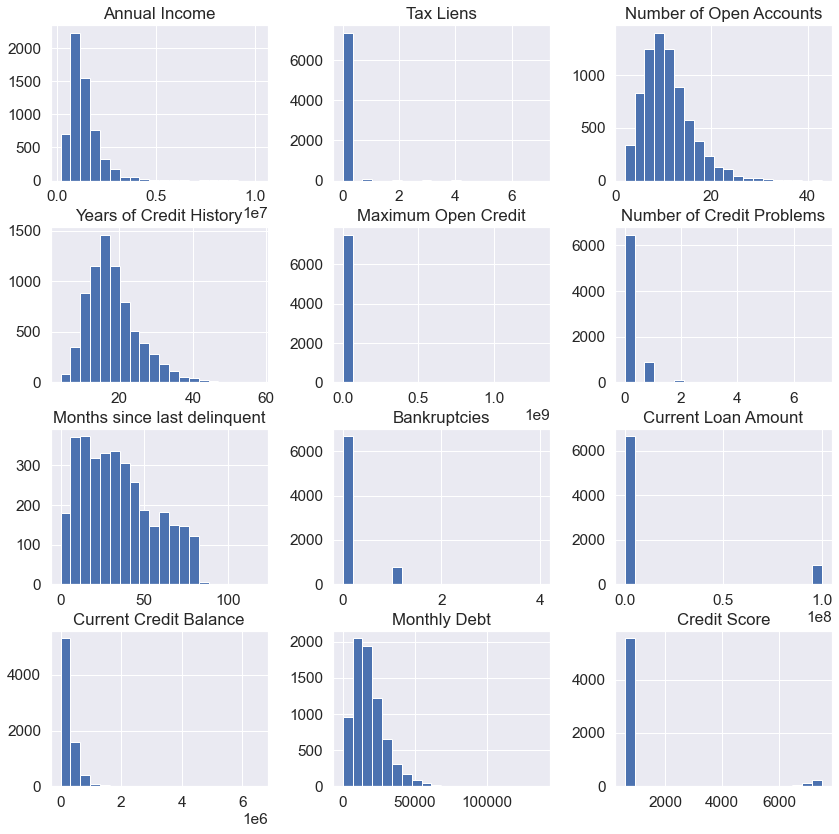

In [22]:
train_df[feature_num_names].hist(figsize=(14,14), bins=20, grid=True);

**Обзор категориальных переменных** 

In [23]:
train_df.describe(include='object')

,Home Ownership,Years in current job,Purpose,Term
count,7500,7129,7500,7500
unique,4,11,15,2
top,Home Mortgage,10+ years,debt consolidation,Short Term
freq,3637,2332,5944,5556


In [24]:
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

**Purpose**

In [25]:
#Вообще я хотела добавить эти значения в other - но я не поняла как

In [26]:
train_df.loc[train_df['Purpose'] == 'renewable energy', 'Purpose'] = train_df['Purpose'].mode()[0]
test_df.loc[train_df['Purpose'] == 'renewable energy ', 'Purpose'] = test_df['Purpose'].mode()[0]

In [27]:
train_df.loc[train_df['Purpose'] == 'vacation', 'Purpose'] = train_df['Purpose'].mode()[0]
test_df.loc[train_df['Purpose'] == 'vacation', 'Purpose'] = test_df['Purpose'].mode()[0]

In [28]:
train_df.loc[train_df['Purpose'] == 'educational expenses', 'Purpose'] = train_df['Purpose'].mode()[0]
test_df.loc[train_df['Purpose'] == 'educational expenses', 'Purpose'] = test_df['Purpose'].mode()[0]

In [29]:
train_df.loc[train_df['Purpose'] == 'moving', 'Purpose'] = train_df['Purpose'].mode()[0]
test_df.loc[train_df['Purpose'] == 'moving', 'Purpose'] = test_df['Purpose'].mode()[0]

**Home Ownership**

In [30]:
train_df.loc[train_df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = train_df['Home Ownership'].mode()[0]
test_df.loc[train_df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = test_df['Home Ownership'].mode()[0]

**Term**

In [31]:
#Тут тоже мб накуролесила,не знаю - хотела перевести в бинарные переменные - но они перевелись в int, 
#а от int надо стараться избавляться

In [32]:
train_df.Term=train_df.Term.map({'Short Term':0,'Long Term ':1})
test_df.Term=test_df.Term.map({'Short Term':0,'Long Term ':1})

In [33]:
train_df['Term'] = train_df['Term'].astype(str)
test_df['Term'] = test_df['Term'].astype(str)

In [34]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### Обработка пропусков

In [35]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5943.00,7500.00,7500.00,7500.00,7500.00,7500.00,3419.00,7486.00,7500.00,7500.00,7500.00,5943.00,7500.00
mean,1366391.72,0.03,11.13,18.32,945153.73,0.17,34.69,0.12,11873177.45,289833.24,18314.45,1151.09,0.28
std,845339.20,0.27,4.91,7.04,16026216.67,0.50,21.69,0.35,31926122.97,317871.38,11926.76,1604.45,0.45
min,164597.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,11242.00,0.00,0.00,585.00,0.00
25%,844341.00,0.00,8.00,13.50,279229.50,0.00,16.00,0.00,180169.00,114256.50,10067.50,711.00,0.00
50%,1168386.00,0.00,10.00,17.00,478159.00,0.00,32.00,0.00,309573.00,209323.00,16076.50,731.00,0.00
75%,1640137.00,0.00,14.00,21.80,793501.50,0.00,50.00,0.00,519882.00,360406.25,23818.00,743.00,1.00
max,10149344.00,7.00,43.00,57.70,1304726170.00,7.00,118.00,4.00,99999999.00,6506797.00,136679.00,7510.00,1.00


In [36]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

**Annual Income**

In [37]:
train_df['Annual Income'].value_counts()

1161660.00    4
1058376.00    4
1338113.00    4
1043651.00    4
969475.00     4
             ..
1141254.00    1
7907382.00    1
1534478.00    1
972040.00     1
1654786.00    1
Name: Annual Income, Length: 5478, dtype: int64

In [38]:
train_df['Annual Income'].fillna(train_df['Annual Income'].median(), inplace=True)
test_df['Annual Income'].fillna(test_df['Annual Income'].median(), inplace=True)

**Years in current job**

In [39]:
train_df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [40]:
train_df['Years in current job'].fillna(train_df['Years in current job'].mode()[0], inplace=True)
test_df['Years in current job'].fillna(test_df['Years in current job'].mode()[0], inplace=True)

**Months since last delinquent**

In [41]:
train_df['Months since last delinquent'].value_counts()

14.00     76
29.00     71
8.00      68
33.00     68
13.00     65
          ..
86.00      1
92.00      1
118.00     1
84.00      1
91.00      1
Name: Months since last delinquent, Length: 89, dtype: int64

In [42]:
train_df['Months since last delinquent'].fillna(train_df['Months since last delinquent'].median(), inplace=True)
test_df['Months since last delinquent'].fillna(test_df['Months since last delinquent'].median(), inplace=True)

**Bankruptcies**

In [43]:
train_df['Bankruptcies'].value_counts()

0.00    6660
1.00     786
2.00      31
3.00       7
4.00       2
Name: Bankruptcies, dtype: int64

In [44]:
train_df['Bankruptcies'].fillna(train_df['Bankruptcies'].mode()[0], inplace=True)
test_df['Bankruptcies'].fillna(test_df['Bankruptcies'].mode()[0], inplace=True)

**Credit Score**

In [45]:
train_df['Credit Score'].value_counts()

740.00     169
747.00     168
748.00     157
745.00     152
741.00     151
          ... 
602.00       1
616.00       1
585.00       1
620.00       1
7010.00      1
Name: Credit Score, Length: 268, dtype: int64

In [46]:
train_df['Credit Score'].fillna(train_df['Annual Income'].median(), inplace=True)
test_df['Credit Score'].fillna(test_df['Annual Income'].median(), inplace=True)

In [47]:
train_df.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

### Обработка выбросов

In [48]:
train_df[feature_num_names].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00
mean,1325285.73,0.03,11.13,18.32,945153.73,0.17,33.23,0.12,11873177.45,289833.24,18314.45,243469.06
std,756755.14,0.27,4.91,7.04,16026216.67,0.50,14.70,0.35,31926122.97,317871.38,11926.76,473451.08
min,164597.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,11242.00,0.00,0.00,585.00
25%,931133.00,0.00,8.00,13.50,279229.50,0.00,32.00,0.00,180169.00,114256.50,10067.50,718.00
50%,1168386.00,0.00,10.00,17.00,478159.00,0.00,32.00,0.00,309573.00,209323.00,16076.50,738.00
75%,1499974.00,0.00,14.00,21.80,793501.50,0.00,32.00,0.00,519882.00,360406.25,23818.00,6930.00
max,10149344.00,7.00,43.00,57.70,1304726170.00,7.00,118.00,4.00,99999999.00,6506797.00,136679.00,1168386.00


In [49]:
train_df[feature_num_names].nunique()

Annual Income                   5478
Tax Liens                          8
Number of Open Accounts           39
Years of Credit History          408
Maximum Open Credit             6963
Number of Credit Problems          8
Months since last delinquent      89
Bankruptcies                       5
Current Loan Amount             5386
Current Credit Balance          6592
Monthly Debt                    6716
Credit Score                     269
dtype: int64

**Tax Liens**

In [50]:
train_df['Tax Liens'].value_counts()

0.00    7366
1.00      83
2.00      30
3.00      10
4.00       6
5.00       2
6.00       2
7.00       1
Name: Tax Liens, dtype: int64

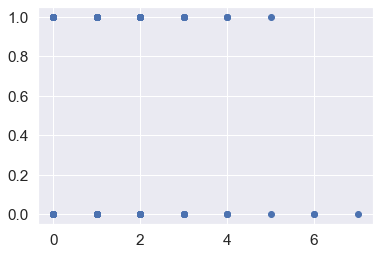

In [51]:
plt.scatter(train_df['Tax Liens'], train_df['Credit Default']);

In [52]:
train_df.loc[(train_df['Tax Liens'] > 3), 'Tax Liens'] = train_df['Tax Liens'].mode()[0]
test_df.loc[(test_df['Tax Liens'] > 3), 'Tax Liens'] = test_df['Tax Liens'].mode()[0]

In [53]:
train_df['Tax Liens'].value_counts()

0.00    7377
1.00      83
2.00      30
3.00      10
Name: Tax Liens, dtype: int64

**Number of Credit Problems**

In [54]:
train_df['Number of Credit Problems'].value_counts()

0.00    6469
1.00     882
2.00      93
3.00      35
4.00       9
5.00       7
6.00       4
7.00       1
Name: Number of Credit Problems, dtype: int64

In [55]:
train_df.loc[(train_df['Number of Credit Problems'] > 3), 'Number of Credit Problems'] = \
train_df['Number of Credit Problems'].mode()[0]

test_df.loc[(train_df['Number of Credit Problems'] > 3), 'Number of Credit Problems'] = \
test_df['Number of Credit Problems'].mode()[0]

**Bankruptcies**

In [56]:
train_df['Bankruptcies'].value_counts()

0.00    6674
1.00     786
2.00      31
3.00       7
4.00       2
Name: Bankruptcies, dtype: int64

In [57]:
train_df.loc[(train_df['Bankruptcies'] > 3), 'Bankruptcies'] = train_df['Bankruptcies'].mode()[0]
test_df.loc[(test_df['Bankruptcies'] > 3), 'Bankruptcies'] = test_df['Bankruptcies'].mode()[0]

### Построение новых признаков

**Преобразуем категориальные признаки в бинарные**

In [58]:
for cat_colname in train_df.select_dtypes(include='object').columns[1:]:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[cat_colname], prefix=cat_colname)], axis=1)
    
for cat_colname in test_df.select_dtypes(include='object').columns[1:]:
    test_df = pd.concat([test_df, pd.get_dummies(test_df[cat_colname], prefix=cat_colname)], axis=1)    

**Month Income**

In [59]:
train_df['Month Income'] = train_df['Annual Income'].apply(lambda x: x / 12)
test_df['Month Income'] = test_df['Annual Income'].apply(lambda x: x / 12)

**Available funds**

In [60]:
train_df['Available funds'] = train_df['Month Income'] - train_df['Monthly Debt']
test_df['Available funds'] = test_df['Month Income'] - test_df['Monthly Debt']

### Отбор данных

**Базовые и новые признаки**

In [61]:
base_feature_names

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [62]:
new_feature_names = train_df.columns.drop([target_name] + base_feature_names).tolist()
new_feature_names

['Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_< 1 year',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_other',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_wedding',
 'Term_0.0',
 'Term_nan',
 'Month Income',
 'Available funds']

**Корреляция новых признаков в разрезе целевой переменной**

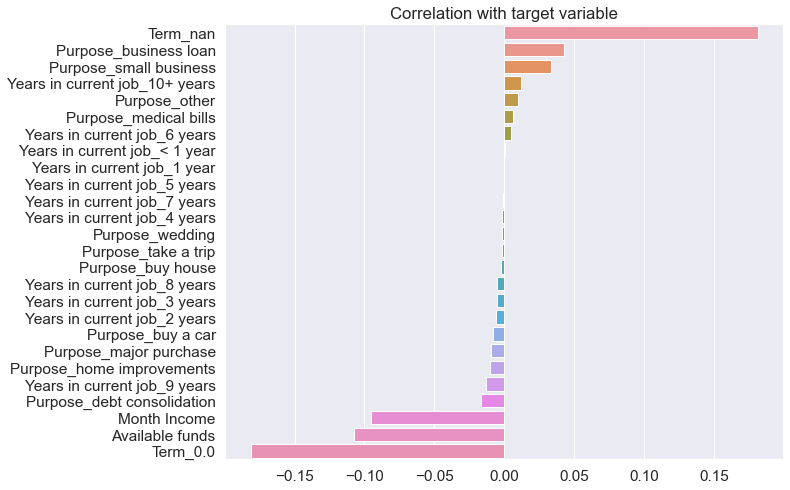

In [63]:
corr_with_target = train_df[new_feature_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Отбор признаков

In [64]:
num_feature_names = []
['Annual Income','Number of Open Accounts','Years of Credit History','Maximum Open Credit','Number of Credit Problems',
 'Months since last delinquent','Bankruptcies','Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score']

cat_feature_names = ['Home Ownership', 'Years in current job','Purpose', 'Term']

selected_feature_names = num_feature_names + new_feature_names

**Функции**

In [65]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [66]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

### Разбиение на train и test

In [67]:
X = train_df[selected_feature_names]
y = train_df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной

In [68]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [69]:
X_train = df_balanced.drop(columns=target_name)
y_train = df_balanced[target_name]

### Сохранение обучающего и тестового датасетов

In [70]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [71]:
#train_df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
#train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
#test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Построение и оценка модели

### K ближайших соседей

In [72]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.80      0.77      3771
           1       0.72      0.65      0.68      2958

    accuracy                           0.73      6729
   macro avg       0.73      0.72      0.73      6729
weighted avg       0.73      0.73      0.73      6729

TEST

              precision    recall  f1-score   support

           0       0.73      0.69      0.71      1616
           1       0.30      0.34      0.32       634

    accuracy                           0.59      2250
   macro avg       0.52      0.52      0.52      2250
weighted avg       0.61      0.59      0.60      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1116  500
1                416  218


**Обучение и оценка финальной модели**

In [73]:
%%time

final_model = model_knn

final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.80      0.77      3771
           1       0.72      0.65      0.68      2958

    accuracy                           0.73      6729
   macro avg       0.73      0.72      0.73      6729
weighted avg       0.73      0.73      0.73      6729

TEST

              precision    recall  f1-score   support

           0       0.73      0.69      0.71      1616
           1       0.30      0.34      0.32       634

    accuracy                           0.59      2250
   macro avg       0.52      0.52      0.52      2250
weighted avg       0.61      0.59      0.60      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1116  500
1                416  218
CPU times: user 323 ms, sys: 3.64 ms, total: 327 ms
Wall time: 325 ms


In [74]:
preds = pd.DataFrame()
preds['Id'] = X_test.index
preds['Credit Default'] = y_test_pred
preds.head()

,Id,Credit Default
0,6079,1
1,6322,0
2,5231,0
3,5360,1
4,3518,1


In [75]:
preds.to_csv('Christina.Yarochkina_predictions.csv', encoding='utf-8',index=False)